# Introduction

Customers churn is a very important part of ecommerce business. By keeping a customer within the service longer, companies not just able to bring in more revenue from the same customer, they can also spend less advertising money while maintaining growth. 

For this churn analysis, the goal is two fold: feature extraction to identify key markers that could potentially explain why customers leave and a model that can predict possible churn customer. Predicting churn is a binary classification on inherently imbalance data. Afterall, for a prosperous business, churn will be small part of customers cohort. Here, I will also take additional steps to deal with imbalance data.

The overall outline of this analysis will be broken down as following:

1) **Data cleaning and visualization**: Exploratory data analysis with visualization;
 
 
2) **Feature ranking**:combining stability randomized logistic regression, linear model, recursive feature elimination, and xgboost to create a feature ranking matrix;


3) **Model selection**:

    - compare baseline models: logistic regression, Naive Bayes, random forest, and xgboost;
    
    - compare result with and without resampling techniques (SMOTE + Tomek);
    
    - Tuning model parameters, and compare results of three different tuning strategy: gridsearchcv, randomizesearchcv, and evolutionsearch.

Data of this analysis is coming from [here](http://srepho.github.io/Churn/Churn).

## 1. Data Cleansing and Analysis

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
color = sns.color_palette()
pd.set_option('display.max_columns',100)
%matplotlib inline

In [131]:
df = pd.read_csv('churn.csv')
df.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [132]:
print (df.shape)
print (df.isnull().any())
print (df.dtypes)

(3333, 21)
State             False
Account Length    False
Area Code         False
Phone             False
Int'l Plan        False
VMail Plan        False
VMail Message     False
Day Mins          False
Day Calls         False
Day Charge        False
Eve Mins          False
Eve Calls         False
Eve Charge        False
Night Mins        False
Night Calls       False
Night Charge      False
Intl Mins         False
Intl Calls        False
Intl Charge       False
CustServ Calls    False
Churn?            False
dtype: bool
State              object
Account Length      int64
Area Code           int64
Phone              object
Int'l Plan         object
VMail Plan         object
VMail Message       int64
Day Mins          float64
Day Calls           int64
Day Charge        float64
Eve Mins          float64
Eve Calls           int64
Eve Charge        float64
Night Mins        float64
Night Calls         int64
Night Charge      float64
Intl Mins         float64
Intl Calls          int64
Intl 

In [133]:
# Use lower case for all columns names
# Drop the "phone" column. Explanation below.
df.columns = df.columns.str.lower().str.replace(' ','_')
df.rename(columns={'churn?':'churn', "int'l_plan":'intl_plan'}, inplace=True)
df.drop('phone', axis=1, inplace=True)

On quick inspection, the dataset looks clean without any missing value, and with a mixture of categorical, ordinal, and numerical data. With about 3300 row of data, the dataset is not big, so must algorithms will run in reasonable time with this dataset.

It is reasonable to assume the "phone" column will not provide much useful information, so we can drop it. As for the "state" column, it may contain useful information, but doing One-Hot encoding for fitting with linear model will dramatically increase the dimension of the dataset. We will determine if "state" column needed to be dropped after the feature ranking analysis.

Before we proceed further, for sake of sanity, let's check if there are any uneven distribution on the "State" columns.


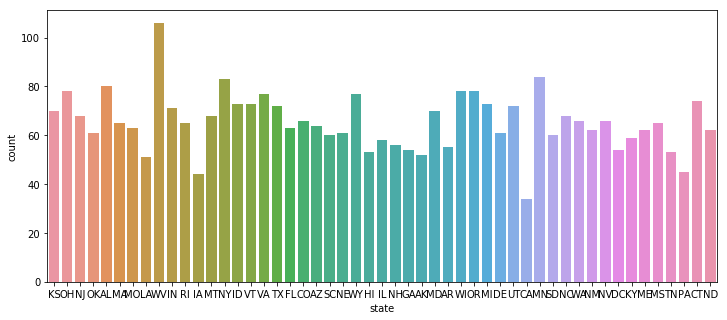

In [7]:
plt.figure(figsize=(12,5))
sns.countplot(x='state', data=df);

We see the Wisconsin has more users than any other states, and California has relatively little users with respect the population of the state. However, on the whole, nothing stands out as abnormal in this plot.

Next, let's check distribution of each variable.

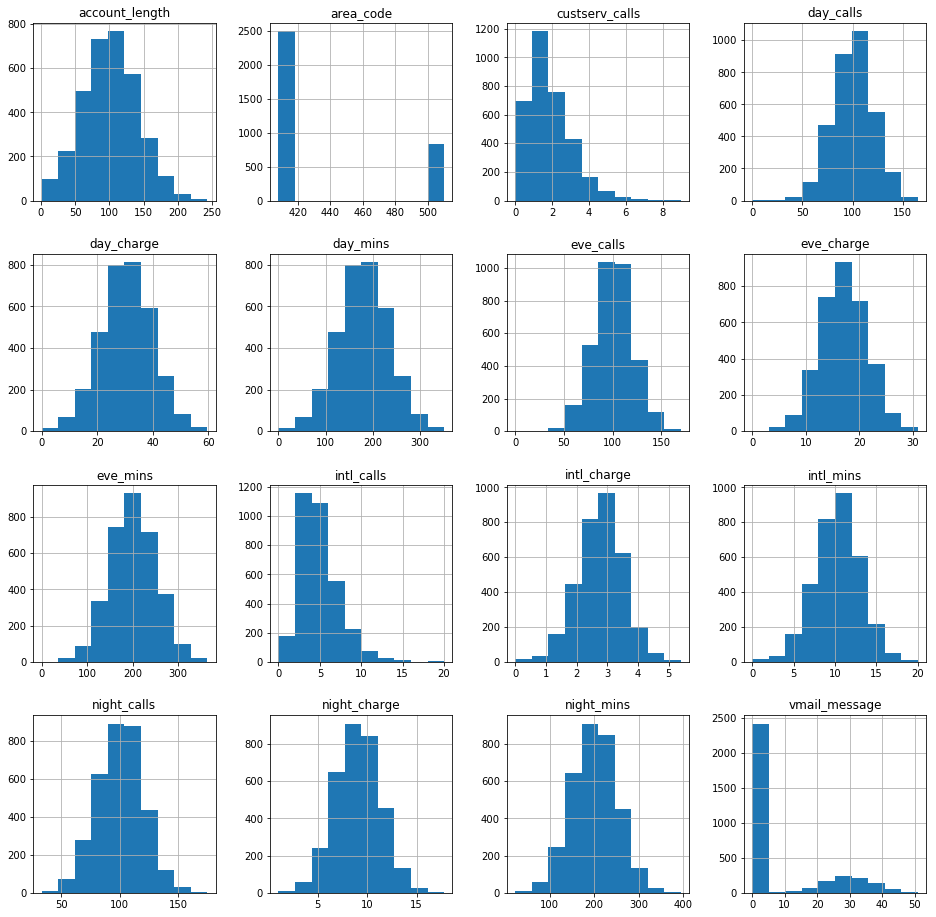

In [134]:
df.hist(figsize=(16,16));

There are nice spread for each variable, albeit that some variables have a slight skew in their distribution. Again, nothing stands out as it need additional attention.

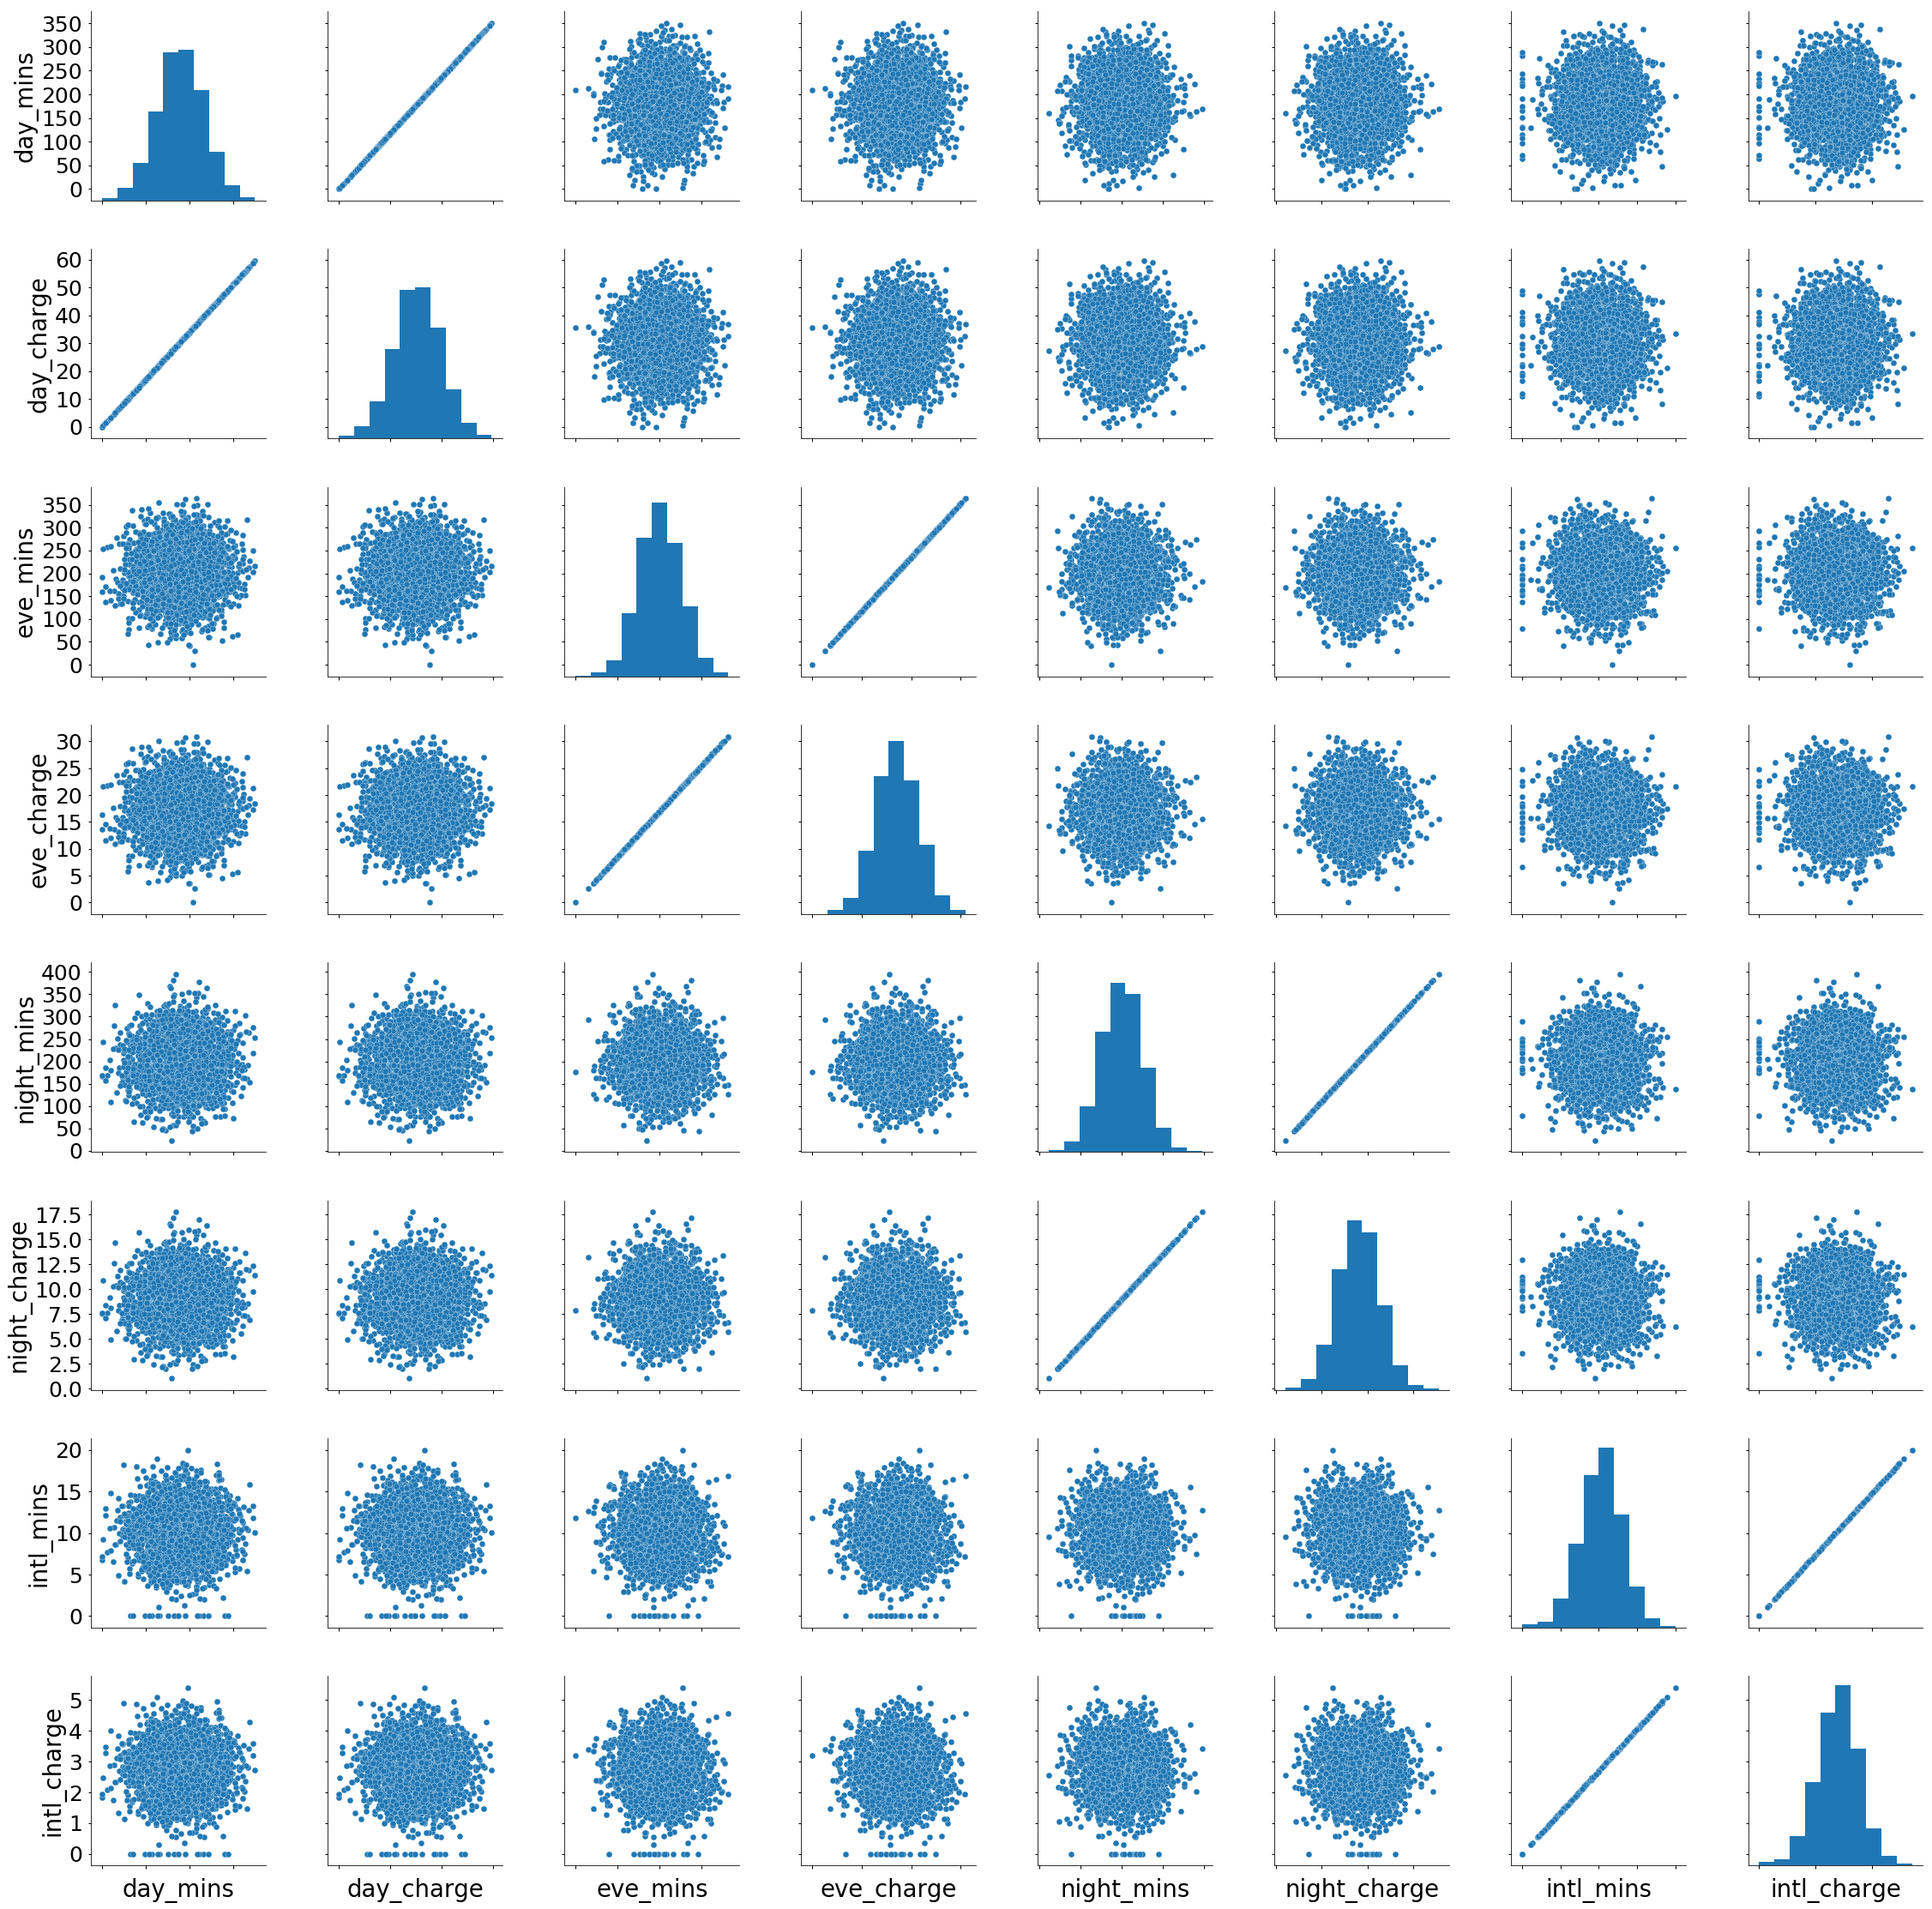

In [140]:
yes_no_col = ["intl_plan", 'vmail_plan']
discrete_col = ['account_length', 'vmail_message', 'day_calls', 'eve_calls','night_calls', 
                'intl_calls','custserv_calls']
continous_col = ['day_mins','day_charge','eve_mins','eve_charge','night_mins','night_charge','intl_mins','intl_charge']
cat_col = ['state','area_code']

with sns.plotting_context("notebook",font_scale=2.5):
    g = sns.pairplot(df[continous_col] ,size=4)
g.set(xticklabels=[]);

So the columns "day_charge", "eve_charge", "night_charge" and "intl_charge" are just multiple of the columns "day_mins", "eve_mins", "night_mins" and "intl_mins", respectively. We can drop all of these columns.

In [141]:
df.drop(['day_charge','eve_charge','night_charge','intl_charge'], axis=1, inplace=True)

Percentage of churn is 14.5 %


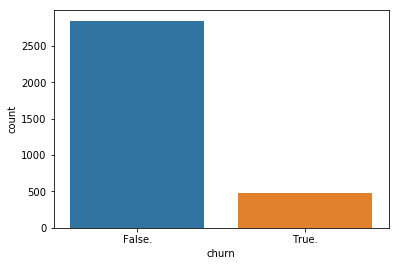

In [142]:
print ('Percentage of churn is %.1f %%'%(len(df[df['churn']=='True.'])/len(df)*100))
sns.countplot(x='churn', data = df);

As expected, the churn customers are in the minority. In this case, only 14.5% of customers turn away, which also mean that a naive approach of labeling all customers as "stay" will yield an accuracy of 85.5%. Clearly, accuracy will not be an effective measure of a model's performance. In fact, here we mostly care about recall, i.e. amongst those who churn, how many we correctly identify. Thus, f1-score and confusion matrix will be more appropriate measure of model performance. 

In [143]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in df.dtypes[df.dtypes==object].index.values:
    df[col] = le.fit_transform(df[col])

churn_summary = df.copy()
churn_summary.drop(cat_col, axis=1, inplace=True)

churn_summary.groupby('churn').mean().T

churn,0,1
account_length,100.793684,102.664596
int'l_plan,0.065263,0.283644
vmail_plan,0.295439,0.165631
vmail_message,8.604561,5.115942
day_mins,175.175754,206.914079
day_calls,100.283158,101.335404
eve_mins,199.043298,212.410145
eve_calls,100.038596,100.561077
night_mins,200.133193,205.231677
night_calls,100.058246,100.399586


There appear to be a noticable difference in mean for the variables "int'l_plan", "vmail_plan", "day_mins" and "custserv_calls". Let check these difference more closely.

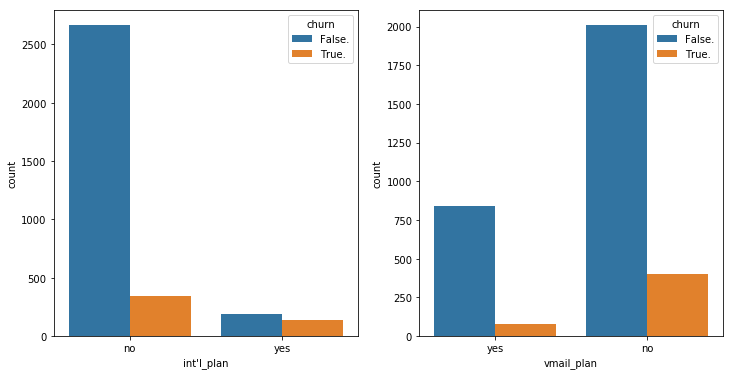

In [139]:
fig, axs = plt.subplots(ncols=len(yes_no_col), figsize=(12,6))
for i, col in enumerate(yes_no_col):
    sns.countplot(x=col, hue = 'churn',data=df, ax=axs[i])

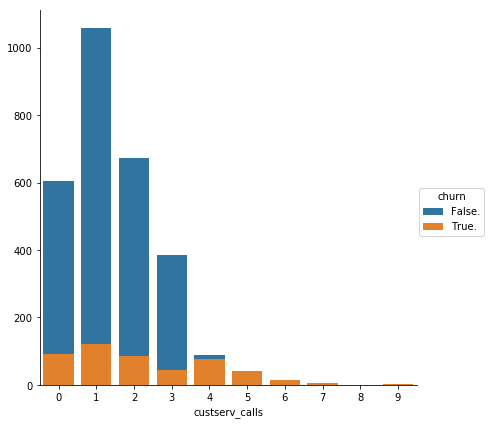

In [135]:
g = sns.FacetGrid(df, hue="churn", size=6)
g = g.map(sns.countplot, "custserv_calls").add_legend()

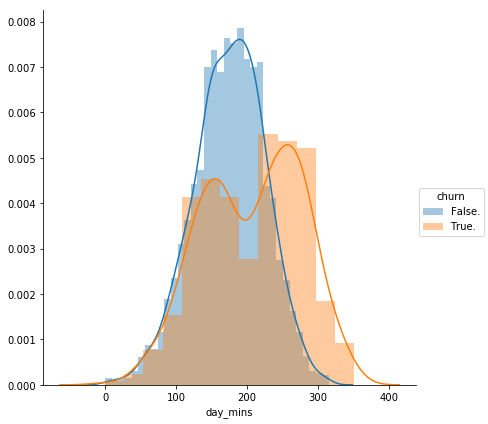

In [138]:
g = sns.FacetGrid(df, hue="churn", size=6)
g = g.map(sns.distplot, "day_mins").add_legend() #kdeplot

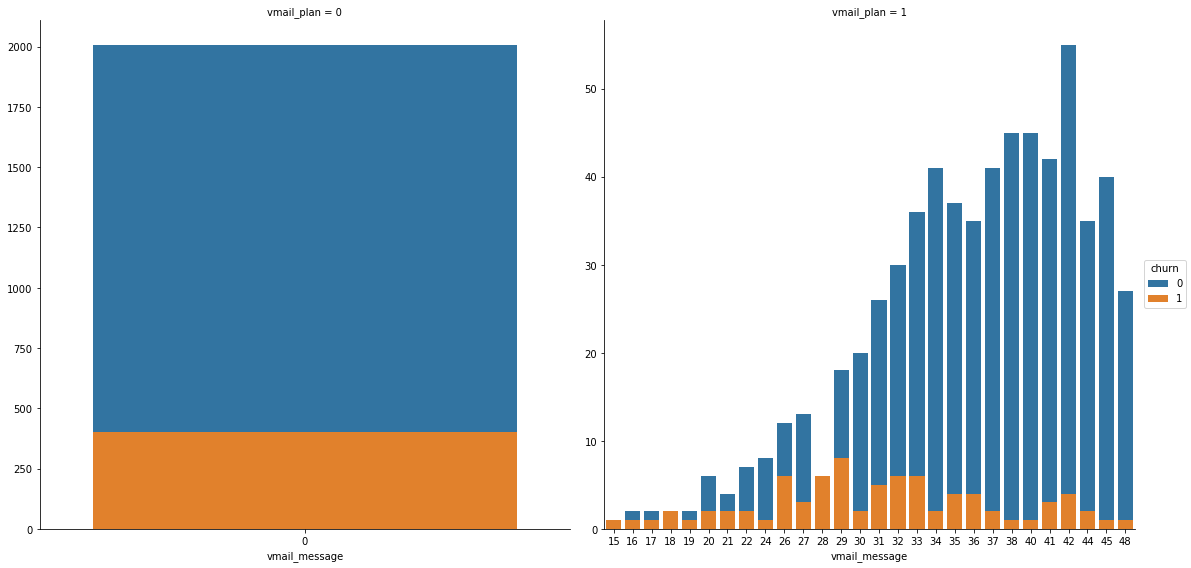

In [151]:
g = sns.FacetGrid(df, hue="churn",col='vmail_plan', size=8, sharex=False, sharey=False)
g = g.map(sns.countplot, "vmail_message").add_legend()

Looking at each variable individually, having international plan or not having a voice messaging plan increases the likelihood of churning. Also, having at least 4 customer service calls or day minimum greater than 250 increases the likelihood of churning too.

Last, let's look at the coorelation between each variable.

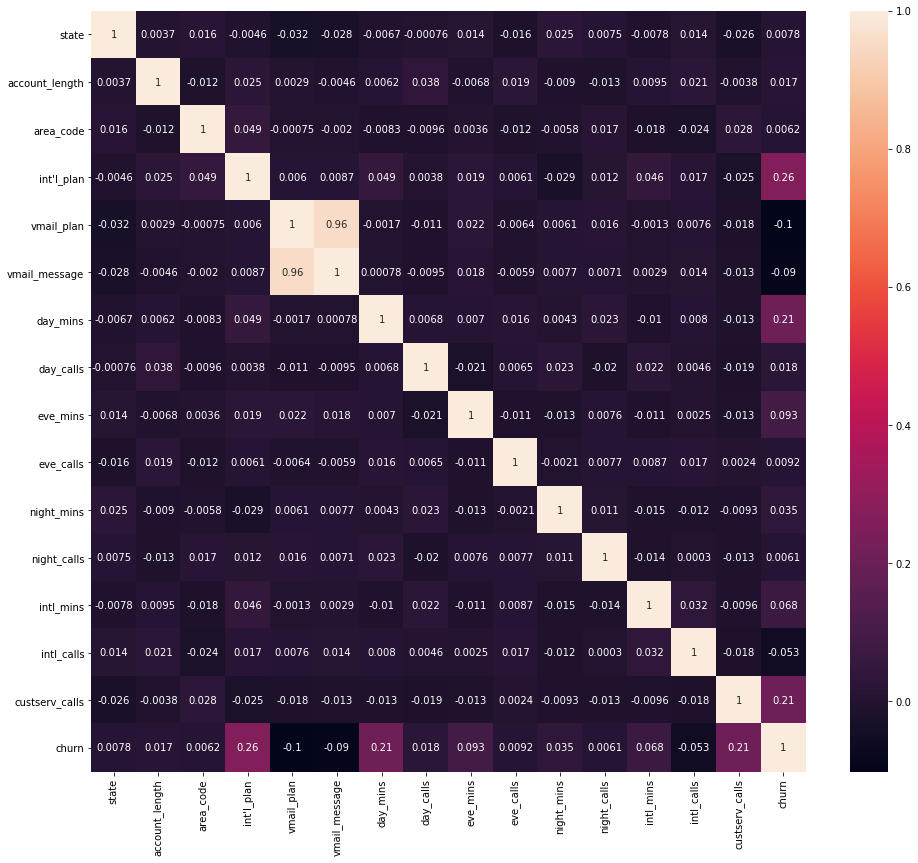

In [122]:
plt.figure(figsize=(16,14))
sns.heatmap(df.corr(), annot=True);

## PCA

In [171]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap

# Normalize data
dataset = df.copy()
N = StandardScaler()

N.fit(dataset)

dataset_norm = N.transform(dataset)

In [172]:
# PCA
pca = PCA(n_components=2)
pca_representation = pca.fit_transform(dataset_norm)

In [173]:
# Isomap
iso = Isomap(n_components=2, n_neighbors=40)
iso_representation = iso.fit_transform(dataset_norm)

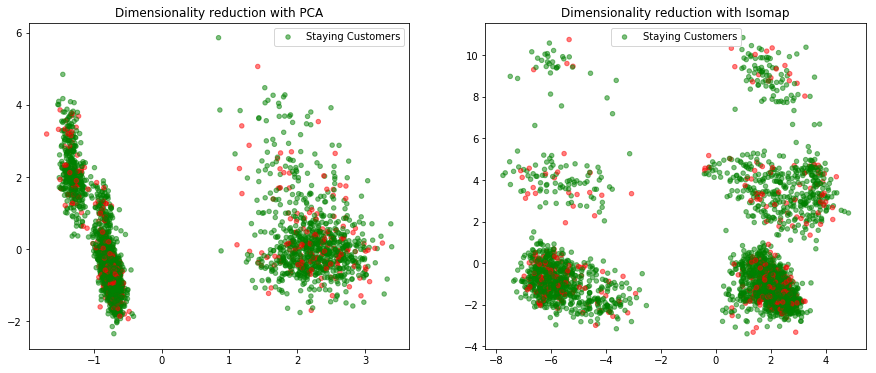

In [174]:
#Plot graph
churn_colors = dataset["churn"].map(lambda s : "g" if s==0 else "r")

fig, axes = plt.subplots(1,2,figsize=(15,6))

axes[0].scatter(pca_representation[:,0],pca_representation[:,1],
            c = churn_colors[index],alpha=0.5,s=20)
axes[0].set_title("Dimensionality reduction with PCA")
axes[0].legend(["Staying Customers"])

axes[1].scatter(iso_representation[:,0],iso_representation[:,1],
            c = churn_colors[index],alpha=0.5,s=20)
axes[1].set_title("Dimensionality reduction with Isomap")
axes[1].legend(["Staying Customers"])

Relevant Links:

1) http://blog.keyrus.co.uk/a_simple_approach_to_predicting_customer_churn.html

2) https://towardsdatascience.com/predict-customer-churn-with-r-9e62357d47b4

3) http://srepho.github.io/Churn/Churn

4) https://www.kaggle.com/stevenfelix/predicting-churn/notebook

5) https://www.kaggle.com/randylaosat/predicting-employee-kernelover

Useful description on Pipeline:

https://www.civisanalytics.com/blog/workflows-in-python-using-pipeline-and-gridsearchcv-for-more-compact-and-comprehensive-code/

Good description on feature selection:

https://www.kaggle.com/arthurtok/feature-ranking-rfe-random-forest-linear-models

http://blog.datadive.net/selecting-good-features-part-iv-stability-selection-rfe-and-everything-side-by-side/